# Analisis dan Prediksi hasil dari GLCM dan rata-rata Histogram Color pada citra jenis ikan menggunakan metode Random Forest Regressor

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Code di atas digunakan untuk mengimpor beberapa library yang diperlukan dalam pengolahan gambar dan data. Modul 'os' digunakan untuk berinteraksi dengan sistem operasi, 'cv2' adalah pustaka OpenCV yang berguna untuk manipulasi gambar dan video,  'numpy' untuk operasi numerik, 'pandas' untuk membaca dan memanipulasi data, 'matplotlib.pyplot' untuk membuat plot grafik, dan 'train_test_split' dari pustaka sklearn untuk membagi data menjadi set pelatihan dan pengujian. Dengan mengimpor modul-modul ini, kita dapat menggunakan fungsi-fungsi dan metode-metode yang disediakan oleh pustaka-pustaka tersebut dalam pengembangan perangkat lunak.

#### Import Dataset Citra Jenis-Jenis Ikan

In [2]:
def load_dataset(data_dir):
    images = []
    labels = []
    class_names = os.listdir(data_dir)
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            image_files = os.listdir(class_dir)[:5]
            for image_file in image_files:
                image_path = os.path.join(class_dir, image_file)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                images.append(image)
                labels.append(i)
    return images, labels, class_names

dataset_dir = 'ikan'
images, labels, class_names = load_dataset(dataset_dir)
unique_values = set(labels)
count_labels = len(unique_values)

print("Jumlah citra:", len(images))
print("Jumlah label:", count_labels)
print("Kelas ikan:", class_names)

Jumlah citra: 15
Jumlah label: 3
Kelas ikan: ['Anthias Anthias', 'Dasyatis Centroura', 'Trigloporus Lastoviza']


Code di atas berfungsi untuk memuat dataset gambar pada direktori 'ikan'. Fungsi 'load_dataset' membaca gambar-gambar dari setiap kelas dalam direktori tersebut, mengonversi skema warna gambar menjadi RGB, dan menyimpannya dalam daftar gambar (images). Fungsi juga menyimpan label gambar (labels) dan daftar nama kelas (class_names). Setelah memuat dataset, kode mencetak jumlah gambar, jumlah label, dan nama kelas dari dataset yang dimuat.

#### Preprocessing

In [3]:
def resize_images(images, target_size):
    resized_images = []
    for image in images:
        height, width, _ = image.shape
        scale_x = target_size[0] / width
        scale_y = target_size[1] / height
        resized_image = np.zeros((target_size[1], target_size[0], image.shape[2]), dtype=np.uint8)

        for y in range(target_size[1]):
            for x in range(target_size[0]):
                src_x = int(x / scale_x)
                src_y = int(y / scale_y)
                resized_image[y, x] = image[src_y, src_x]
        resized_images.append(resized_image)
        
    return resized_images

Fungsi code di atas digunakan untuk merubah ukuran gambar-gambar dalam sebuah daftar ke ukuran target yang ditentukan. Fungsi ini mengiterasi melalui setiap gambar dalam daftar gambar yang diberikan, dan menghitung skala perubahan ukuran yang diperlukan berdasarkan perbandingan antara ukuran target dengan ukuran asli gambar. Kemudian, fungsi membuat gambar dengan ukuran target yang baru dan mengisi piksel-pikselnya dengan piksel-piksel yang sesuai dari gambar asli menggunakan perhitungan skala. Gambar-gambar yang diubah ukurannya kemudian ditambahkan ke dalam daftar gambar yang baru (resized_images) dan dikembalikan oleh fungsi.

In [4]:
target_size = (256,256)

resized_images = resize_images(images, target_size)

Fungsi code di atas digunakan untuk mengubah ukuran gambar-gambar dalam daftar menjadi ukuran (256, 256). Fungsi melakukan perhitungan skala perubahan ukuran, membuat gambar dengan ukuran target baru, dan mengisi piksel-pikselnya dengan piksel-piksel yang sesuai dari gambar asli. Hasilnya, gambar-gambar yang telah diubah ukurannya disimpan dalam daftar yang dikembalikan oleh fungsi.

In [5]:
def normalize_images(images):
    normalized_images = []
    for image in images:
        min_value = np.min(image)
        max_value = np.max(image)
        normalized_image = np.zeros_like(image, dtype=np.float32)
        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                normalized_pixel = (image[y, x] - min_value) / (max_value - min_value)
                normalized_image[y, x] = normalized_pixel
        normalized_images.append(normalized_image)

    return normalized_images

Code di atas digunakan untuk normalisasi gambar-gambar dalam daftar. Melakukan normalisasi pada setiap gambar dengan memperhitungkan nilai minimum dan maksimum piksel dalam gambar. Setiap piksel gambar diubah menjadi nilai normalisasi yang berkisar antara 0 hingga 1. Setelah normalisasi, gambar-gambar yang telah dinormalisasi disimpan dalam daftar yang dikembalikan oleh fungsi.

In [6]:
normalized_images = normalize_images(resized_images)

Code di atas digunakan untuk melakukan normalisasi pada gambar-gambar yang ada dalam daftar "resized_images".

#### Ekstraksi Fitur Warna (Histogram Color)

In [7]:
def extract_color_features(images):
    color_features = []
    for image in images:
        hist_r, _ = np.histogram(image[:, :, 0], bins=256, range=[0, 256])
        hist_g, _ = np.histogram(image[:, :, 1], bins=256, range=[0, 256])
        hist_b, _ = np.histogram(image[:, :, 2], bins=256, range=[0, 256])
        color_features.append(np.concatenate((hist_r, hist_g, hist_b)))
    return color_features

Code di atas berfungsi untuk mengekstraksi fitur warna dari gambar-gambar dalam daftar. Melakukan perhitungan histogram untuk masing-masing saluran warna dalam gambar. Histogram tersebut merepresentasikan distribusi intensitas warna dalam setiap saluran warna. Setiap histogram direpresentasikan sebagai array, dan ketiga array histogram dari saluran R, G, dan B digabungkan menjadi satu array fitur warna untuk setiap gambar. Hasilnya, daftar fitur warna ini, yang mencakup fitur-fitur warna dari semua gambar dalam daftar, akan dikembalikan oleh fungsi.

In [8]:
color_features = extract_color_features(normalized_images)

Code di atas berfungsi untuk menghitung dan mengekstraksi fitur warna dari gambar-gambar yang telah dinormalisasi dalam daftar 'normalized_images'.

In [9]:
def calculate_mean_color(color_features):
    mean_colors = []
    for color_feature in color_features:
        num_bins = 256
        num_channels = 3
        hist_length = num_bins * num_channels
        hist_r = color_feature[:num_bins]
        hist_g = color_feature[num_bins:2*num_bins]
        hist_b = color_feature[2*num_bins:]
        bins = np.arange(num_bins)
        mean_r = np.sum(hist_r * bins) / np.sum(hist_r)
        mean_g = np.sum(hist_g * bins) / np.sum(hist_g)
        mean_b = np.sum(hist_b * bins) / np.sum(hist_b)
        mean_colors.append((mean_r, mean_g, mean_b))
    return mean_colors

Code di atas berfungsi untuk menghitung rata-rata warna dari fitur-fitur warna dalam daftar 'color_features'. Melakukan perhitungan rata-rata untuk setiap warna (R, G, B) berdasarkan histogram fitur warna. Hasilnya, fungsi mengembalikan daftar rata-rata warna dalam bentuk tupel (R, G, B) yang mewakili rata-rata warna dari setiap gambar dalam daftar fitur warna.

In [10]:
rata_color = calculate_mean_color(color_features)

Code di atas berfungsi untuk menghitung rata-rata warna dari fitur-fitur warna dalam daftar 'color_features'.

In [11]:
for i, mean_color in enumerate(rata_color):
    print("Citra", i+1)
    print("Rata-rata Warna (R, G, B):", mean_color)
    print()

Citra 1
Rata-rata Warna (R, G, B): (0.3813018798828125, 0.3756866455078125, 0.3758392333984375)

Citra 2
Rata-rata Warna (R, G, B): (0.0016937255859375, 0.0001373291015625, 0.0018463134765625)

Citra 3
Rata-rata Warna (R, G, B): (1.52587890625e-05, 0.0, 0.0)

Citra 4
Rata-rata Warna (R, G, B): (0.0881195068359375, 1.52587890625e-05, 0.00018310546875)

Citra 5
Rata-rata Warna (R, G, B): (1.52587890625e-05, 0.0, 0.0)

Citra 6
Rata-rata Warna (R, G, B): (0.00079345703125, 0.0017852783203125, 0.000762939453125)

Citra 7
Rata-rata Warna (R, G, B): (0.00067138671875, 0.00506591796875, 0.000762939453125)

Citra 8
Rata-rata Warna (R, G, B): (0.1378173828125, 0.1707305908203125, 0.149871826171875)

Citra 9
Rata-rata Warna (R, G, B): (0.0289459228515625, 0.0308837890625, 0.038299560546875)

Citra 10
Rata-rata Warna (R, G, B): (0.0009307861328125, 0.0006256103515625, 0.0004425048828125)

Citra 11
Rata-rata Warna (R, G, B): (0.0016632080078125, 0.0008087158203125, 0.0003509521484375)

Citra 12
Rat

Code di atas berfungsi untuk menampilkan rata-rata warna (R, G, B) dari setiap gambar dalam daftar 'rata_color'. Melalui perulangan, nomor gambar beserta nilai rata-rata warna dicetak.

#### Ekstraksi Fitur Tekstur (GLCM)

In [12]:
def calcGLCM(image, distances, angle):
    image = np.array(image, dtype=np.uint8)
    x, y, _ = image.shape

    sx = int(distances * np.cos(angle * 3.14 / 180))
    sy = int(distances * np.sin(angle * 3.14 / 180))

    shift_img = np.roll(image, sx, axis=1)
    shift_img = np.roll(shift_img, sy, axis=0)

    max_gray_level = np.max(image) + 1
    glcm = np.zeros((max_gray_level, max_gray_level), dtype=np.uint8)
    for i in range(x):
        for j in range(y):
            if i + sx >= 0 and i + sx < x and j + sy >= 0 and j + sy < y:
                glcm[image[i, j, 0], shift_img[i + sx, j + sy, 0]] += 1

    return glcm

def extract_glcms_0(image):
    distances = 1
    angle = 0
    glcm = calcGLCM(image, distances, angle)
    return glcm

def extract_glcms_45(image):
    distances = 1
    angle = 45
    glcm = calcGLCM(image, distances, angle)
    return glcm

def extract_glcms_90(image):
    distances = 1
    angle = 90
    glcm = calcGLCM(image, distances, angle)
    return glcm

def extract_glcms_135(image):
    distances = 1
    angle = 135
    glcm = calcGLCM(image, distances, angle)
    return glcm

Code di atas berfungsi untuk menghitung dan mengekstraksi matriks (GLCM). Terdapat empat fungsi: extract_glcms_0, extract_glcms_45, extract_glcms_90, dan extract_glcms_135, yang masing-masing menghitung GLCM dengan sudut yang berbeda (0 derajat, 45 derajat, 90 derajat, dan 135 derajat). Setiap fungsi menggunakan fungsi calcGLCM untuk melakukan perhitungan GLCM dengan jarak dan sudut yang ditentukan. Hasil GLCM kemudian dikembalikan sebagai output fungsi masing-masing. GLCM adalah representasi statistik yang menggambarkan hubungan spasial antara intensitas piksel dalam gambar, dan dapat digunakan sebagai fitur dalam analisis citra atau pengenalan pola.

In [13]:
def extract_features(normalized_images):
    features = []
    
    total_images = len(normalized_images)
    for idx, img in enumerate(normalized_images):
        dat = []
        dat.append(np.ravel(extract_glcms_0(img)))
        dat.append(np.ravel(extract_glcms_45(img)))
        dat.append(np.ravel(extract_glcms_90(img)))
        dat.append(np.ravel(extract_glcms_135(img)))
        features.append(dat)
        
        progress = (idx + 1) / total_images * 100
        print(f"Ekstraksi fitur GLCM: {progress:.2f}%", end="\r")
        
    print("Ekstraksi fitur GLCM: 100.00%")
        
    return features

# extraction_texture_feature = np.array(extract_features(resized_images))
extraction_texture_feature = np.array(extract_features(normalized_images))

Ekstraksi fitur GLCM: 100.00%


Code di atas berfungsi untuk mengekstraksi fitur tekstur menggunakan (GLCM) dari setiap gambar dalam daftar 'normalized_images'. Fungsi 'extract_features' melakukan perulangan melalui setiap gambar, dan untuk setiap gambar, menggunakan fungsi-fungsi 'extract_glcms_*' untuk menghitung GLCM dengan sudut yang berbeda. Fitur-fitur GLCM kemudian diratakan (flattened) dan disusun ke dalam bentuk array 2D.

In [14]:
def contrast(glcm):
    if len(glcm.shape) == 1:
        size = int(np.sqrt(glcm.shape[0]))
        glcm = glcm.reshape((size, size))

    x, y = glcm.shape

    contrast = 0.0
    for i in range(x):
        for j in range(y):
            contrast += (i - j) ** 2 * glcm[i, j]

    return contrast

def dissimilarity(glcm):
    if len(glcm.shape) == 1:
        size = int(np.sqrt(glcm.shape[0]))
        glcm = glcm.reshape((size, size))

    x, y = glcm.shape

    dissimilarity = 0.0
    for i in range(x):
        for j in range(y):
            dissimilarity += abs(i - j) * glcm[i, j]

    return dissimilarity

def homogeneity(glcm):
    if len(glcm.shape) == 1:
        size = int(np.sqrt(glcm.shape[0]))
        glcm = glcm.reshape((size, size))

    x, y = glcm.shape

    homogeneity = 0.0
    for i in range(x):
        for j in range(y):
            homogeneity += glcm[i, j] / (1 + abs(i - j))

    return homogeneity

def entropy(glcm):
    if len(glcm.shape) == 1:
        size = int(np.sqrt(glcm.shape[0]))
        glcm = glcm.reshape((size, size))

    eps = 1e-8
    entropy = -np.sum(glcm * np.log2(glcm + eps))

    return entropy

def asm(glcm):
    if len(glcm.shape) == 1:
        size = int(np.sqrt(glcm.shape[0]))
        glcm = glcm.reshape((size, size))

    asm = np.sum(glcm ** 2)

    return asm

def energy(glcm):
    if len(glcm.shape) == 1:
        size = int(np.sqrt(glcm.shape[0]))
        glcm = glcm.reshape((size, size))

    energy = np.sqrt(np.sum(glcm ** 2))

    return energy

def correlation(glcm):
    if len(glcm.shape) == 1:
        size = int(np.sqrt(glcm.shape[0]))
        glcm = glcm.reshape((size, size))

    x, y = glcm.shape
    mean_i = np.sum(np.arange(x) * np.sum(glcm, axis=1))
    mean_j = np.sum(np.arange(y) * np.sum(glcm, axis=0))
    std_i = np.sqrt(np.sum(((np.arange(x) - mean_i) ** 2) * np.sum(glcm, axis=1)))
    std_j = np.sqrt(np.sum(((np.arange(y) - mean_j) ** 2) * np.sum(glcm, axis=0)))

    if std_i == 0 or std_j == 0:
        std_i = 1 
        std_j = 1

    correlation = 0.0
    for i in range(x):
        for j in range(y):
            correlation += ((i - mean_i) * (j - mean_j) * glcm[i, j]) / (std_i * std_j)

    return correlation

Code di atas berfungsi untuk mengimplementasikan beberapa fungsi statistik yang digunakan untuk matriks GLCM. Fungsi-fungsi tersebut dapat digunakan untuk menghitung kontras, dissimilarity, homogeneity, entropi, ASM, energi, dan korelasi dari matriks GLCM. Fungsi-fungsi ini membantu dalam ekstraksi fitur tekstur dari gambar yang direpresentasikan dalam bentuk matriks GLCM.

In [15]:
result = []
jenis_ikan = ['Anthias Anthias', 'Dasyatis Centroura', 'Trigloporus Lastoviza']

for i in range(min(len(extraction_texture_feature), 15)):
    extracted_data = []
    
    if i < 5:
        extracted_data.append(jenis_ikan[0])
    elif i < 10:
        extracted_data.append(jenis_ikan[1])
    else:
        extracted_data.append(jenis_ikan[2])
    
    for j in extraction_texture_feature[i]:
        extracted_data.append(contrast(j))
        extracted_data.append(dissimilarity(j))
        extracted_data.append(homogeneity(j))
        extracted_data.append(entropy(j))
        extracted_data.append(asm(j))
        extracted_data.append(energy(j))
        extracted_data.append(correlation(j))

    extracted_data.extend(rata_color[i])

    result.append(extracted_data)

angles = ['-0', '-45', '-90', '-135']
headers = []
for angle in angles:
    headers.extend([f'Kontras{angle}', f'Dissimilarity{angle}', f'Homogenitas{angle}', f'Entropi{angle}', f'ASM{angle}', f'Energi{angle}', f'Correlation{angle}'])

for i in range(3):
    headers.append(f'Rata-rata Warna {i+1}')

df_data = []
df_data.append(headers)
df_data.extend(result)

for row in df_data:
    print("\t".join(str(val) for val in row))


Kontras-0	Dissimilarity-0	Homogenitas-0	Entropi-0	ASM-0	Energi-0	Correlation-0	Kontras-45	Dissimilarity-45	Homogenitas-45	Entropi-45	ASM-45	Energi-45	Correlation-45	Kontras-90	Dissimilarity-90	Homogenitas-90	Entropi-90	ASM-90	Energi-90	Correlation-90	Kontras-135	Dissimilarity-135	Homogenitas-135	Entropi-135	ASM-135	Energi-135	Correlation-135	Rata-rata Warna 1	Rata-rata Warna 2	Rata-rata Warna 3
Anthias Anthias	372.0	372.0	326.0	-3733.6673112509748	306	17.4928556845359	0.9999910010059688	0.0	0.0	256.0	-1801.561762992721	146	12.083045973594572	0.9999999999999999	0.0	0.0	256.0	-1801.561762992721	146	12.083045973594572	0.9999999999999999	0.0	0.0	256.0	-1801.561762992721	146	12.083045973594572	0.9999999999999999	0.3813018798828125	0.3756866455078125	0.3758392333984375
Anthias Anthias	208.0	208.0	152.0	-1633.0025780747994	322	17.944358444926362	0.9999667693939728	0.0	0.0	256.0	-1795.2669792458812	66	8.12403840463596	1.0	0.0	0.0	256.0	-1795.2669792458812	66	8.12403840463596	1.0	0.0	0.0	256.0	

Code di atas berfungsi untuk menghasilkan tabel data yang berisi fitur-fitur ekstraksi tekstur (kontras, dissimilarity, homogeneity, entropi, ASM, energi, dan korelasi) dari matriks GLCM pada empat sudut yang berbeda (-0, -45, -90, -135) dan juga rata-rata warna dari sejumlah gambar. Tabel ini digunakan untuk merepresentasikan data hasil ekstraksi fitur secara terstruktur dan digunakan untuk analisis dan pemrosesan selanjutnya.

In [16]:
import csv

def create_feature_csv(data, filename):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)

        writer.writerows(data)
        
filename = 'dataset.csv'
create_feature_csv(df_data, filename)


Code di atas berfungsi untuk membuat file CSV yang berisi data fitur dalam format tabel yang telah dihasilkan sebelumnya. Fungsi 'create_feature_csv' menerima data tabel (df_data) dan nama file (filename) sebagai input, kemudian menulis data ke dalam file CSV dengan menggunakan modul csv.

#### Analisis Regresi terhadap Dataset

In [17]:
df_dataset = pd.read_csv('dataset.csv')

df_dataset.head()

,Kontras-0,Dissimilarity-0,Homogenitas-0,Entropi-0,ASM-0,Energi-0,Correlation-0,Kontras-45,Dissimilarity-45,Homogenitas-45,...,Kontras-135,Dissimilarity-135,Homogenitas-135,Entropi-135,ASM-135,Energi-135,Correlation-135,Rata-rata Warna 1,Rata-rata Warna 2,Rata-rata Warna 3
Anthias Anthias,372.0,372.0,326.0,-3733.667311,306,17.492856,0.999991,0.0,0.0,256.0,...,0.0,0.0,256.0,-1801.561763,146,12.083046,1.0,0.381302,0.375687,0.375839
Anthias Anthias,208.0,208.0,152.0,-1633.002578,322,17.944358,0.999967,0.0,0.0,256.0,...,0.0,0.0,256.0,-1795.266979,66,8.124038,1.0,0.001694,0.000137,0.001846
Anthias Anthias,2.0,2.0,255.0,-2029.125910,6,2.449490,0.996078,0.0,0.0,256.0,...,0.0,0.0,256.0,-2038.560126,2,1.414214,1.0,0.000015,0.000000,0.000000
Anthias Anthias,409.0,409.0,563.5,-5828.450147,594,24.372115,0.999998,0.0,0.0,256.0,...,0.0,0.0,256.0,-1794.541824,450,21.213203,1.0,0.088120,0.000015,0.000183
Anthias Anthias,2.0,2.0,255.0,-2029.125910,6,2.449490,0.996078,0.0,0.0,256.0,...,0.0,0.0,256.0,-2038.560126,2,1.414214,1.0,0.000015,0.000000,0.000000


Code diatas merupakan proses membaca dataset dengan format (.csv) dan menampilkan bagian header dari datasetnya.

In [18]:
# df_dataset = df_dataset.fillna(0.0)
df_dataset = df_dataset.dropna()

df_dataset.head()

,Kontras-0,Dissimilarity-0,Homogenitas-0,Entropi-0,ASM-0,Energi-0,Correlation-0,Kontras-45,Dissimilarity-45,Homogenitas-45,...,Kontras-135,Dissimilarity-135,Homogenitas-135,Entropi-135,ASM-135,Energi-135,Correlation-135,Rata-rata Warna 1,Rata-rata Warna 2,Rata-rata Warna 3
Anthias Anthias,372.0,372.0,326.0,-3733.667311,306,17.492856,0.999991,0.0,0.0,256.0,...,0.0,0.0,256.0,-1801.561763,146,12.083046,1.0,0.381302,0.375687,0.375839
Anthias Anthias,208.0,208.0,152.0,-1633.002578,322,17.944358,0.999967,0.0,0.0,256.0,...,0.0,0.0,256.0,-1795.266979,66,8.124038,1.0,0.001694,0.000137,0.001846
Anthias Anthias,2.0,2.0,255.0,-2029.125910,6,2.449490,0.996078,0.0,0.0,256.0,...,0.0,0.0,256.0,-2038.560126,2,1.414214,1.0,0.000015,0.000000,0.000000
Anthias Anthias,409.0,409.0,563.5,-5828.450147,594,24.372115,0.999998,0.0,0.0,256.0,...,0.0,0.0,256.0,-1794.541824,450,21.213203,1.0,0.088120,0.000015,0.000183
Anthias Anthias,2.0,2.0,255.0,-2029.125910,6,2.449490,0.996078,0.0,0.0,256.0,...,0.0,0.0,256.0,-2038.560126,2,1.414214,1.0,0.000015,0.000000,0.000000


Code diatas merupakan proses menghapus nilai-nilai 'NaN' pada setiap fitur atau kolom

In [19]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, Anthias Anthias to Trigloporus Lastoviza
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Kontras-0          15 non-null     float64
 1   Dissimilarity-0    15 non-null     float64
 2   Homogenitas-0      15 non-null     float64
 3   Entropi-0          15 non-null     float64
 4   ASM-0              15 non-null     int64  
 5   Energi-0           15 non-null     float64
 6   Correlation-0      15 non-null     float64
 7   Kontras-45         15 non-null     float64
 8   Dissimilarity-45   15 non-null     float64
 9   Homogenitas-45     15 non-null     float64
 10  Entropi-45         15 non-null     float64
 11  ASM-45             15 non-null     int64  
 12  Energi-45          15 non-null     float64
 13  Correlation-45     15 non-null     float64
 14  Kontras-90         15 non-null     float64
 15  Dissimilarity-90   15 non-null     float64
 16  

Code diatas merupakan proses untuk mendapatkan informasi dari dataset menggunakan fungsi .info()

In [20]:
texture_start_col, texture_end_col = 1 , 28
texture_subset_data = df_dataset.iloc[:, texture_start_col:texture_end_col]
texture_subset_array = texture_subset_data.values
texture_mean_values = np.mean(texture_subset_array, axis=1)

print("Rata-rata nilai Ekstraksi Fitur Tekstur (GLCM):")
print(texture_mean_values)

Rata-rata nilai Ekstraksi Fitur Tekstur (GLCM):
[-254.46705984 -197.20322501 -262.85622522 -275.39125536 -262.85622522
 -187.77218579 -185.19512706 -265.9201835  -202.92903611 -170.66886355
 -168.0449607  -262.85622522 -243.39291838 -169.73780091 -262.85622522]


Code diatas merupakan proses menghitung nilai rata-rata dari hasil ekstraksi fitur tekstur menggunakan metode GLCM.

In [21]:
color_start_col, color_end_col = 29, 31
color_subset_data = df_dataset.iloc[:, color_start_col:color_end_col]
color_subset_array = color_subset_data.values
color_mean_values = np.mean(color_subset_array, axis=1)

print("Rata-rata nilai Ekstraksi Fitur Warna (Histogram Color):")
print(color_mean_values)

Rata-rata nilai Ekstraksi Fitur Warna (Histogram Color):
[3.75762939e-01 9.91821289e-04 0.00000000e+00 9.91821289e-05
 0.00000000e+00 1.27410889e-03 2.91442871e-03 1.60301208e-01
 3.45916748e-02 5.34057617e-04 5.79833984e-04 4.42504883e-04
 0.00000000e+00 0.00000000e+00 7.62939453e-06]


Code diatas merupakan proses menghitung nilai rata-rata dari hasil ekstraksi fitur warna menggunakan metode Histogram warna.

In [22]:
df_dataset['Mean Tekstur'] = texture_mean_values
df_dataset['Mean Warna'] = color_mean_values
# df_dataset = df_dataset.drop(['texture_mean_values', 'color_mean_values'], axis=1)
df_dataset.head()

,Kontras-0,Dissimilarity-0,Homogenitas-0,Entropi-0,ASM-0,Energi-0,Correlation-0,Kontras-45,Dissimilarity-45,Homogenitas-45,...,Homogenitas-135,Entropi-135,ASM-135,Energi-135,Correlation-135,Rata-rata Warna 1,Rata-rata Warna 2,Rata-rata Warna 3,Mean Tekstur,Mean Warna
Anthias Anthias,372.0,372.0,326.0,-3733.667311,306,17.492856,0.999991,0.0,0.0,256.0,...,256.0,-1801.561763,146,12.083046,1.0,0.381302,0.375687,0.375839,-254.467060,0.375763
Anthias Anthias,208.0,208.0,152.0,-1633.002578,322,17.944358,0.999967,0.0,0.0,256.0,...,256.0,-1795.266979,66,8.124038,1.0,0.001694,0.000137,0.001846,-197.203225,0.000992
Anthias Anthias,2.0,2.0,255.0,-2029.125910,6,2.449490,0.996078,0.0,0.0,256.0,...,256.0,-2038.560126,2,1.414214,1.0,0.000015,0.000000,0.000000,-262.856225,0.000000
Anthias Anthias,409.0,409.0,563.5,-5828.450147,594,24.372115,0.999998,0.0,0.0,256.0,...,256.0,-1794.541824,450,21.213203,1.0,0.088120,0.000015,0.000183,-275.391255,0.000099
Anthias Anthias,2.0,2.0,255.0,-2029.125910,6,2.449490,0.996078,0.0,0.0,256.0,...,256.0,-2038.560126,2,1.414214,1.0,0.000015,0.000000,0.000000,-262.856225,0.000000


Code diatas merupakan proses menambah data rata-rata ekstraksi fitur tekstur dan warna pada dataset.

In [23]:
df_texture = df_dataset.drop(['Rata-rata Warna 1', 'Rata-rata Warna 2', 'Rata-rata Warna 3', 'Mean Warna'], axis=1)
df_color = df_dataset.drop(['Kontras-0', 'Dissimilarity-0', 'Homogenitas-0', 'Entropi-0', 'ASM-0', 'Energi-0', 'Correlation-0', 'Kontras-45', 'Dissimilarity-45', 'Homogenitas-45', 'Entropi-45', 'ASM-45', 'Energi-45', 'Correlation-45', 'Kontras-90', 'Dissimilarity-90', 'Homogenitas-90', 'Entropi-90', 'ASM-90', 'Energi-90', 'Correlation-90', 'Kontras-135', 'Dissimilarity-135', 'Homogenitas-135', 'Entropi-135', 'ASM-135', 'Energi-135', 'Correlation-135', 'Mean Tekstur'], axis=1)

Code diatas merupakan proses membagi dataset menjadi dua bagian, yaitu untuk dataset ekstraksi fitur tekstur dan dataset ekstraksi fitur warna.

In [24]:
df_texture.head()

,Kontras-0,Dissimilarity-0,Homogenitas-0,Entropi-0,ASM-0,Energi-0,Correlation-0,Kontras-45,Dissimilarity-45,Homogenitas-45,...,Energi-90,Correlation-90,Kontras-135,Dissimilarity-135,Homogenitas-135,Entropi-135,ASM-135,Energi-135,Correlation-135,Mean Tekstur
Anthias Anthias,372.0,372.0,326.0,-3733.667311,306,17.492856,0.999991,0.0,0.0,256.0,...,12.083046,1.0,0.0,0.0,256.0,-1801.561763,146,12.083046,1.0,-254.467060
Anthias Anthias,208.0,208.0,152.0,-1633.002578,322,17.944358,0.999967,0.0,0.0,256.0,...,8.124038,1.0,0.0,0.0,256.0,-1795.266979,66,8.124038,1.0,-197.203225
Anthias Anthias,2.0,2.0,255.0,-2029.125910,6,2.449490,0.996078,0.0,0.0,256.0,...,1.414214,1.0,0.0,0.0,256.0,-2038.560126,2,1.414214,1.0,-262.856225
Anthias Anthias,409.0,409.0,563.5,-5828.450147,594,24.372115,0.999998,0.0,0.0,256.0,...,21.213203,1.0,0.0,0.0,256.0,-1794.541824,450,21.213203,1.0,-275.391255
Anthias Anthias,2.0,2.0,255.0,-2029.125910,6,2.449490,0.996078,0.0,0.0,256.0,...,1.414214,1.0,0.0,0.0,256.0,-2038.560126,2,1.414214,1.0,-262.856225


In [25]:
df_color.head()

,Rata-rata Warna 1,Rata-rata Warna 2,Rata-rata Warna 3,Mean Warna
Anthias Anthias,0.381302,0.375687,0.375839,0.375763
Anthias Anthias,0.001694,0.000137,0.001846,0.000992
Anthias Anthias,0.000015,0.000000,0.000000,0.000000
Anthias Anthias,0.088120,0.000015,0.000183,0.000099
Anthias Anthias,0.000015,0.000000,0.000000,0.000000


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Code diatas merupakan proses import library yang dibutuhkan untuk melakukan Regresi dengan metode Random Forest Regressor

In [27]:
rf = RandomForestRegressor()

Code diatas merupakan proses membuat objek RandomForestRegressor

In [28]:
t_x = df_texture[['Kontras-0', 'Dissimilarity-0', 'Homogenitas-0', 'Entropi-0', 'ASM-0', 'Energi-0', 'Correlation-0', 'Kontras-45', 'Dissimilarity-45', 'Homogenitas-45', 'Entropi-45', 'ASM-45', 'Energi-45', 'Correlation-45', 'Kontras-90', 'Dissimilarity-90', 'Homogenitas-90', 'Entropi-90', 'ASM-90', 'Energi-90', 'Correlation-90', 'Kontras-135', 'Dissimilarity-135', 'Homogenitas-135', 'Entropi-135', 'ASM-135', 'Energi-135', 'Correlation-135']]
t_y = df_texture['Mean Tekstur']

t_x_train, t_x_test, t_y_train, t_y_test = train_test_split(t_x, t_y, test_size=0.2, random_state=42)

Code diatas merupakan proses membagi dataset tekstur menjadi data train dan data test.

In [29]:
rf.fit(t_x_train, t_y_train)
t_score = rf.score(t_x_test, t_y_test)
print('Score:', t_score)

Score: 0.9788569266465381


Code diatas merupakan proses menghitung score untuk data test dari dataset tekstur

In [30]:
t_y_pred = rf.predict(t_x_test)
t_mse = mean_squared_error(t_y_test, t_y_pred)
print('Mean Texture Squared Error:', t_mse)

Mean Texture Squared Error: 36.62691052109558


Code diatas merupakan proses menghitung Mean Squared Error (MSE) dari data test dengan data predict

In [31]:
c_x = df_color[['Rata-rata Warna 1', 'Rata-rata Warna 2', 'Rata-rata Warna 3']]
c_y = df_color['Mean Warna']

c_x_train, c_x_test, c_y_train, c_y_test = train_test_split(c_x, c_y, test_size=0.2, random_state=42)

Code diatas merupakan proses membagi dataset warna menjadi data train dan data test

In [32]:
rf.fit(c_x_train, c_y_train)
c_score = rf.score(c_x_test, c_y_test)
print('Score:', c_score)

Score: 0.27182691503500755


Code diatas merupakan proses menghitung score untuk data test dari dataset warna

In [33]:
c_y_pred = rf.predict(c_x_test)
c_mse = mean_squared_error(c_y_test, c_y_pred)
print('Mean Color Squared Error:', c_mse)

Mean Color Squared Error: 0.022788755247868053


Code diatas merupakan proses menghitung Mean Squared Error (MSE) dari data test dengan data predict

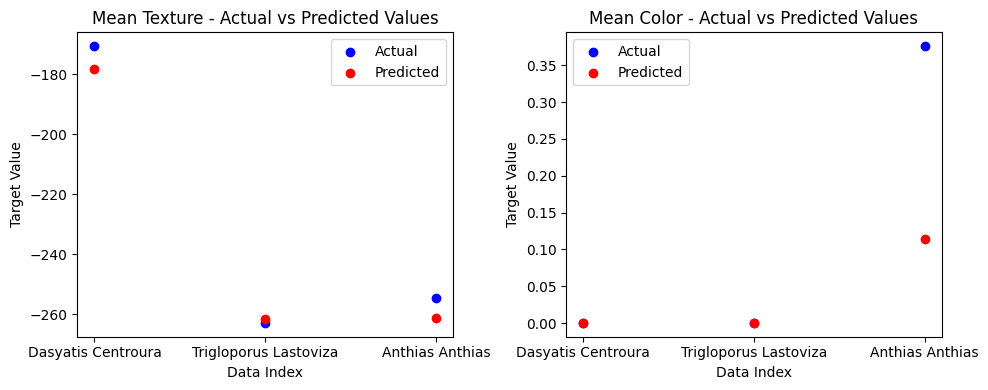

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].scatter(t_x_test.index, t_y_test, color='blue', label='Actual')
axs[0].scatter(t_x_test.index, t_y_pred, color='red', label='Predicted')
axs[0].set_xlabel('Data Index')
axs[0].set_ylabel('Target Value')
axs[0].set_title('Mean Texture - Actual vs Predicted Values')
axs[0].legend()

axs[1].scatter(c_x_test.index, c_y_test, color='blue', label='Actual')
axs[1].scatter(c_x_test.index, c_y_pred, color='red', label='Predicted')
axs[1].set_xlabel('Data Index')
axs[1].set_ylabel('Target Value')
axs[1].set_title('Mean Color - Actual vs Predicted Values')
axs[1].legend()

plt.tight_layout()
plt.show()


Code diatas merupakan tampilan scatter plot untuk memvisualisasikan hasil dari Regresi untuk dataset fitur tekstur dan warna